# Human Activity Recognition with Smartphones
- URL: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones


In [1]:
# import kagglehub

# path = kagglehub.dataset_download('uciml/human-activity-recognition-with-smartphones')

# print('path to dataset files', path)

### Reference
1. https://www.kaggle.com/code/morrisb/what-does-your-smartphone-know-about-you
2. https://www.kaggle.com/code/abheeshthmishra/eda-of-human-activity-recognition
3. https://www.kaggle.com/code/fahadmehfoooz/human-activity-recognition-with-neural-networks

### Import Library

In [2]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time

# To ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # FutureWarning만 무시
# 혹은 모든 경고 무시: warnings.filterwarnings("ignore")


In [3]:
# Load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine boths dataframes
'''To distinguish between train and test data'''
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'

'''Coalescing in the row direction.
test data is added to the end of the train data
reset_index() is used to reset the index of the DataFrame(Ignore existing index)
'''
both_df = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)
both_df['subject'] = '#' + both_df['subject'].astype(str) # subject 실험자

# Create Label
label = both_df.pop('Activity') # Activity is the target variable

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


### which feature are there?
- We can distinguish the features by name.
- Let's use split to count the number of main names.
example
1. tBodyAcc-mean()-X => it have '-', so extract 'tBodyAcc'
2. angle(tBodyAccMean.gravity) => it has '(' not '-', so extract 'angle'

In [4]:
'''
1. Run repeat statement
2. Counter
3. Converting to DataFrame
4. Sort
'''
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns = {0: 'count'}).sort_values('count', ascending = False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


there mainly are 'acc(acceleration)', 'Gyro(gyroscope)' features. A few 'gravitiy' features are there.

### Check Null value and get dataframe info

In [5]:
print('Null Values in DataFrame: {}\n'.format(both_df.isna().sum().sum())) # 1. one sum() is for each column, 2. another sum() is for all columns
both_df.info()

Null Values in DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


Except from the label and newly created 'Data' and 'subject' features, there is only numerical data.

Fortunately there are missing values.

### How are the labels distributed?

In [6]:
label_counts = label.value_counts()
print(label_counts)

n = label_counts.shape[0] #total count
colormap = get_cmap('viridis') # bring color map 'virdis'
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))] #convert rgb to hex / color map want float value

# create bar chart
data = go.Bar(x = label_counts.index, # name
              y = label_counts, 
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

# create figure with data and layout
fig = go.Figure(data = [data], layout = layout)
iplot(fig)

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64


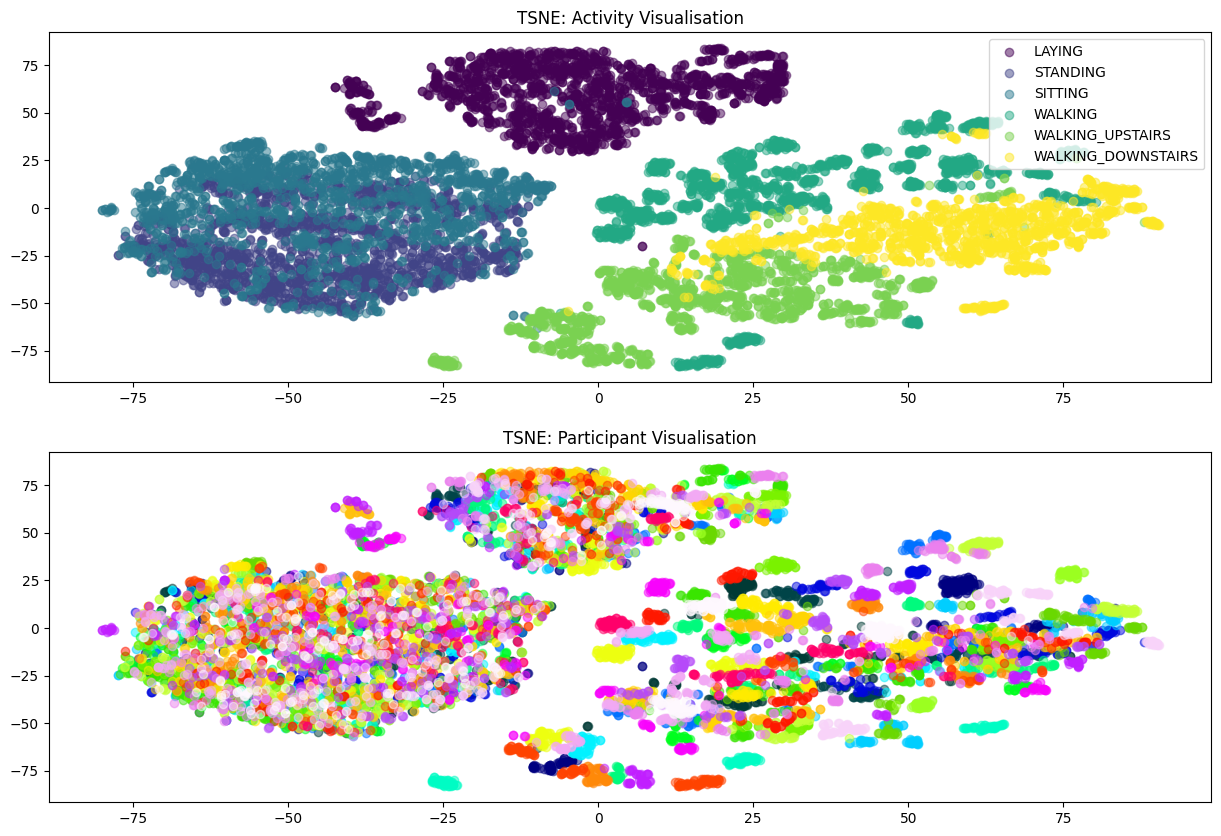

In [7]:
'''
process of data preprocessing, dimensonality reduction, and visualization using t-SNE
'''
# create data

tsne_data = both_df.copy()
# purely for visualiztion (no Data(Train/test), subject)
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tense_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components = 0.9, random_state = 3) # minimum number of components to explain 90% of the variance. for speed up(t-SNE)
tsne_data = pca.fit_transform(tsne_data)

# Transfomr data
## t-SNE(t-distributed Stochasitc Neighbor Embedding): non-linear dimensionality reduction technique well-suited for embedding high-demensional data for visulaization in a low-dimensional space of two or three dimensions
tsne = TSNE(random_state = 3) 
tsne_transformed = tsne.fit_transform(tsne_data)

# create subplt
fig, axarr = plt.subplots(2, 1, figsize = (15, 10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# plot each activity - for classification
## label_counts.index: activity name(6개)
for i, group in enumerate(label_counts.index):
    mask = (label == group).values # same column name [true, false, true, false, ...]
    axarr[0].scatter(x = tsne_transformed[mask][:, 0], y = tsne_transformed[mask][:, 1], c = colors[i], alpha = 0.5, label = group)
    axarr[0].set_title('TSNE: Activity Visualisation')
    axarr[0].legend()

# plot subject - for personalization
# get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    mask = (subject_data == group).values
    axarr[1].scatter(x = tsne_transformed[mask][:, 0], y=tsne_transformed[mask][:, 1], c = colors[i], alpha = 0.5, label = group)
    
axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()


Insight 2: In plot 1, the activities are mostly separable

Insight 3: In plot 2, everybody has an unique/separable walking style Therefore, the smartphone should be able to detect what your are doing and also who is using the smartphone (if you are moving aroun with it)

since the walking data is separated when compartd to other activities, there is a difference in the way each experimenter walks, so individual characteristics are clearly included

## Test the accuracy to see how the activity data are separated

In [8]:
# split traing testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state = 3)

# create the model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
## y_true: actual value, y_pred: predicted_value
score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))


Accuracy on testset:	0.9643



with a basic untuned LGBM model, the activity of smartphone user can be predicted with an accuracy of 96%
This is pretty striking regarding six equally distributed labels.

## Test the accuracy to see how the participants data are separated

In [9]:
# Sore the data
data = []

# Interate over each activity
for activity in label_counts.index:
    # Create a dataset
    act_data = both_df[label == activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')

    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components = 0.9, random_state = 3)
    act_data = pca.fit_transform(act_data)

    # Split training test data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state = 3)

    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
    lgbm = lgbm.fit(X_train, y_train)

    score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6461

Activity: STANDING
Accuracy on testset:	0.5367

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9606

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9148



It seems possible to distinguish what kind of activities the experimenter does. Especially in the walking part, it is possible to distinguish the walking style of 30 different people with 96% accuracy. About 92% of walking upstairs and 91% of waling downstaris. 

What is noteworthy is that the accuracy seems to increase as the participants move.

Insight4: The accuracy increases when subjects moves

Insight5: This means each person's unique walkig/movement style

### How long does the smartphone gate data for this accuracy?

In [10]:
'''
Number of columns of 'Data' groupping labels (standing, walking...) and subject_data(#1, #2,...) in both_df
'''
duration_df = (both_df.groupby([label, subject_data])['Data'] # group by activity and subject each. ## label and subject_data's index is used, so it's possible to user groupby
              .count() # count the number of 'Data' in rows
              .reset_index() # reset and make into DataFrame
              .groupby('Activity') # regroup by activity
              .agg({ 'Data': 'mean' }) * 1.28 # After regrouping to 'Activity', the average of the number of 'Data; is obtained and multiplied by 1.28 (1.28 is the average time in seconds for each activity) ## each subject activity's average time
              ).rename(columns = {'Data' : 'Senconds'})
activity_df = pd.DataFrame(data, columns = ['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Senconds
Activity,,
LAYING,0.646091,82.944000
STANDING,0.536688,81.322667
SITTING,0.530337,75.818667
WALKING,0.960557,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.914773,59.989333


### Which sensor is more important for classifying participants by walking style?
Simple model generation and analysis are conducted to distinguish the walking style of participations

Use feature_importnace in LGBM to find out which value of feature importance is important

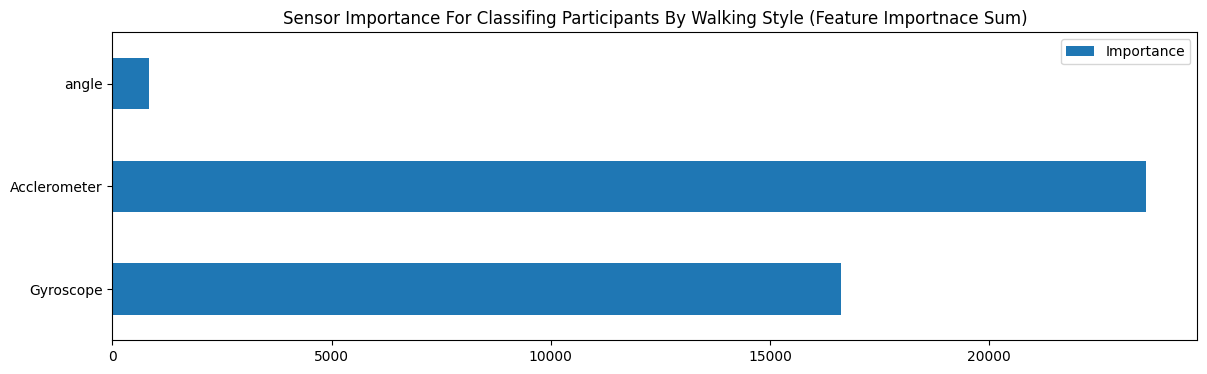

In [11]:
# create dataset
tsne_data = both_df[label == 'WALKING'].copy() # extract only 'WALKING' data, throught the label index
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state = 3)

# Create model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
lgbm = lgbm.fit(X_train, y_train)

# Get importance
features = both_df.drop(['Data', 'subject'], axis = 1).columns
importances = lgbm.feature_importances_

# Sum importances
data = { 'Gyroscope': 0, 'Acclerometer': 0, 'angle': 0 }
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Acclerometer'] += importance
    if 'angle' in feature: # Add angle column because curios about the importance of other features
        data['angle'] += importance

# create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient = 'index').rename(columns = { 0: 'Importance'})
sensor_df.plot(kind = 'barh', figsize = (14,4), title = 'Sensor Importance For Classifing Participants By Walking Style (Feature Importnace Sum)')
plt.show()

The accelerometer supplies slightly more information. Both sensors(acc, gyroscope) are important for classification and refraining from using both sensors will be a drawback for the quality of the model. so use both columns

### what is feature importance?
Feature importance is a score calculated by combining the number of times each feature was used when the model learned or the information gain obtained when splitting.

This score represents the extend to which that feaure contributed to the predicion (classification), and the higher the score, the greater the effect the fatrue had on the model

### How long does the participants use the staircase
The data has been performed nearly the same environment, depending on the scientific environment.

It's highly likelyfor the participants to have been walking up and down the same number of staircases. 

Let us investigate their activity durations

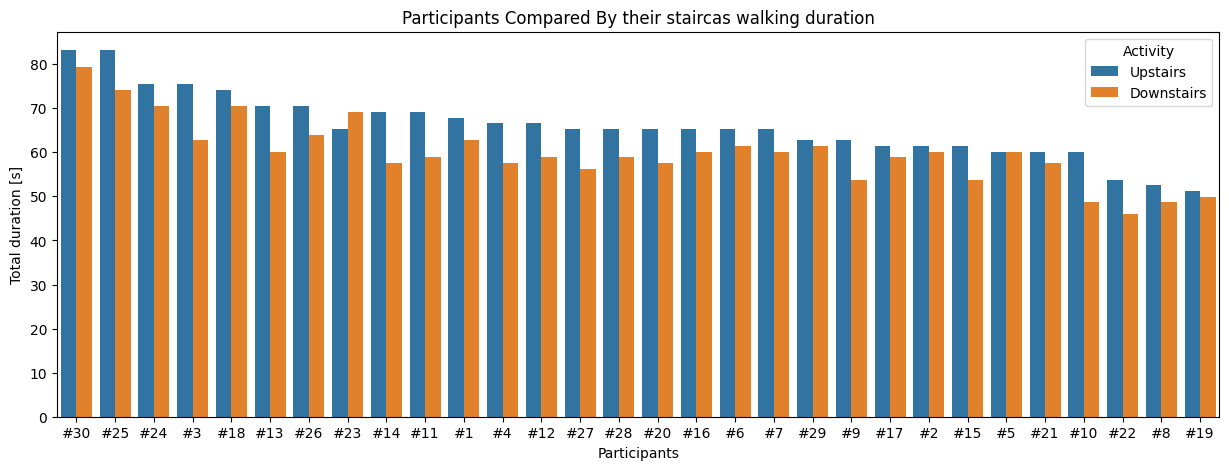

In [12]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data']).count() * 1.28 #both_df[mask] means only truev value is selected so EX) groupby(['WALKING_UPSTAIRS], 'subject')

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending = False)
plot_data['Activity'] = plot_data['Activity'].map({ 'WALKING_UPSTAIRS': 'Upstairs', 'WALKING_DOWNSTAIRS': 'Downstairs'})

plt.figure(figsize = (15, 5))
sns.barplot(data = plot_data, x = 'subject', y = 'Data', hue = 'Activity')
plt.title('Participants Compared By their staircas walking duration')
plt.xlabel('Participants')
plt.ylabel('Total duration [s]')
plt.show()

Nearly all participants have more data for walking upstairs thatn downstaris. Assuming an equal number of up - and down-walks the participants need longer walking upstairs.

Furthermore the range od the duration is narrow and adjusted to the conditions. A young person being ~50% fast in walking upstairs than an older one is reasonable

=> Considering that the participants' ages range from 19 to 48 years, it is reasonable to infer that younger individuals tend to walk upstairs approximately 50% faster that their older counterparts.

## How much does the up-downstairs ratio vary?

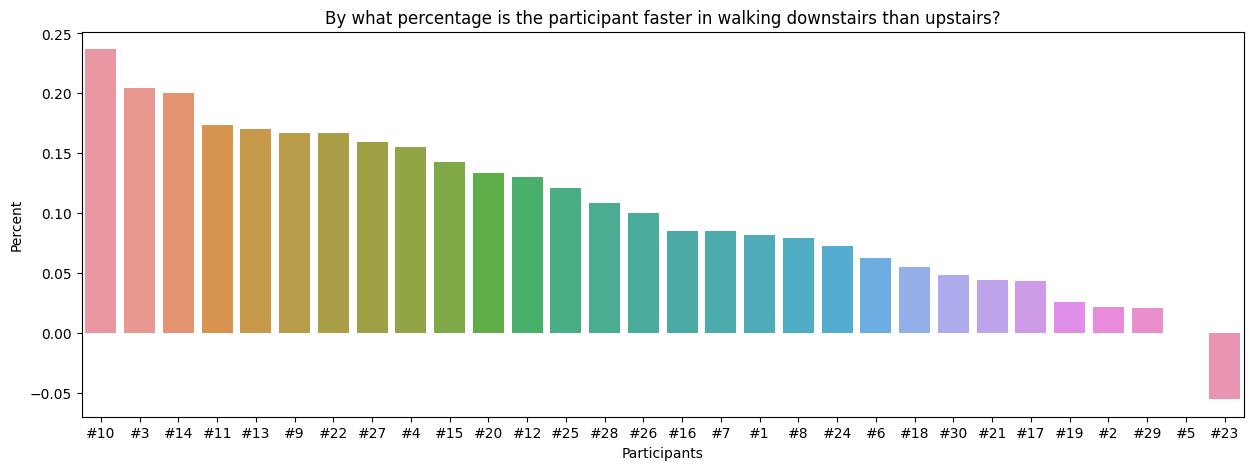

In [13]:
'''
loc: extract the row with the index ex) 'walking_upstaris' and 'walking_downstairs'
-1 is used to calculate the percentage relatively
'''
plt.figure(figsize = (15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending = False)
sns.barplot(x = plot_data.index, y = plot_data)
plt.title('By what percentage is the participant faster in walking downstairs than upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

There is a wide range in between te participants for their ratio of up-/down-walking. Since this represents therir physical condition I can imagine a correlation to their age and health (speculative)

## Are there conspicuities in the staircase walking duration distribution?

C:\Users\vivid\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




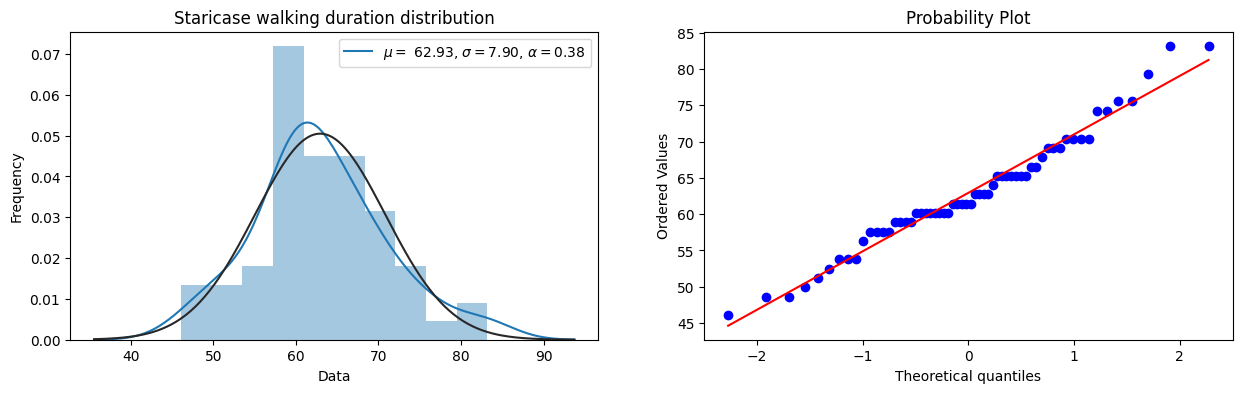

In [14]:
def plotSkew(x):
    (mu, sigma) = norm.fit(x) # scipy.stats.norm.fit(): estimate the parameters of the normal distribution ##정규분포 fit
    alpha = skew(x) # scipy.stats.skew(): skewness of the data ## 왜도계산
    ### skewness: the skewness represents the asymmetry(비대칭) of the distribution, and for a normal distribution, it should ususally be a value close to zero. (0에 가까운 값)

    fig, axarr = plt.subplots(1, 2, figsize = (15, 4))

    # plot label and fit
    sns.distplot(x, fit = norm, ax = axarr[0]) # fit  = norm / axarr: axes(축) numpy array
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma = ${:.2f}, $\\alpha = ${:.2f}'.format(mu, sigma, alpha)], loc = 'best') # $: LaTex: 수학식 표기
    axarr[0].set_title('Staricase walking duration distribution')
    axarr[0].set_ylabel('Frequency')

    # plot probability plot
    res = probplot(x, plot = axarr[1])
    plt.show()

plotSkew(duration_df)

Many statistical analysis methods are designed based on the assumption that data follows a normal distribution.

If the data meets this assumption, these techniques can be applied without issues, increasing the reliability of the results.

In particular, modeling and many machine learning algorithms or predictive models perform more effectively when the data is assumed to follow a normal distribution. Additionally, detecting and handling outliers becomes more efficient under this assumption.

1. Left Graph: The data appears to follow a distribution close to normal. However, the tails (both the left and right ends) may slightly deviate from a perfect normal distribution.
2. Right Graph (Q-Q Plot): The Q-Q plot is a tool for assessing the normality of data. If the points are positioned close to the red line (represention the theoretical normal distribution), the data can be considered normally distributed. While most points are near the red line, the data at both ends (tails) slightly deviate from the line

### As aspected from most real world data the duration walking on the staircase is normally distributed

### Is there a unique walking style for each participant?

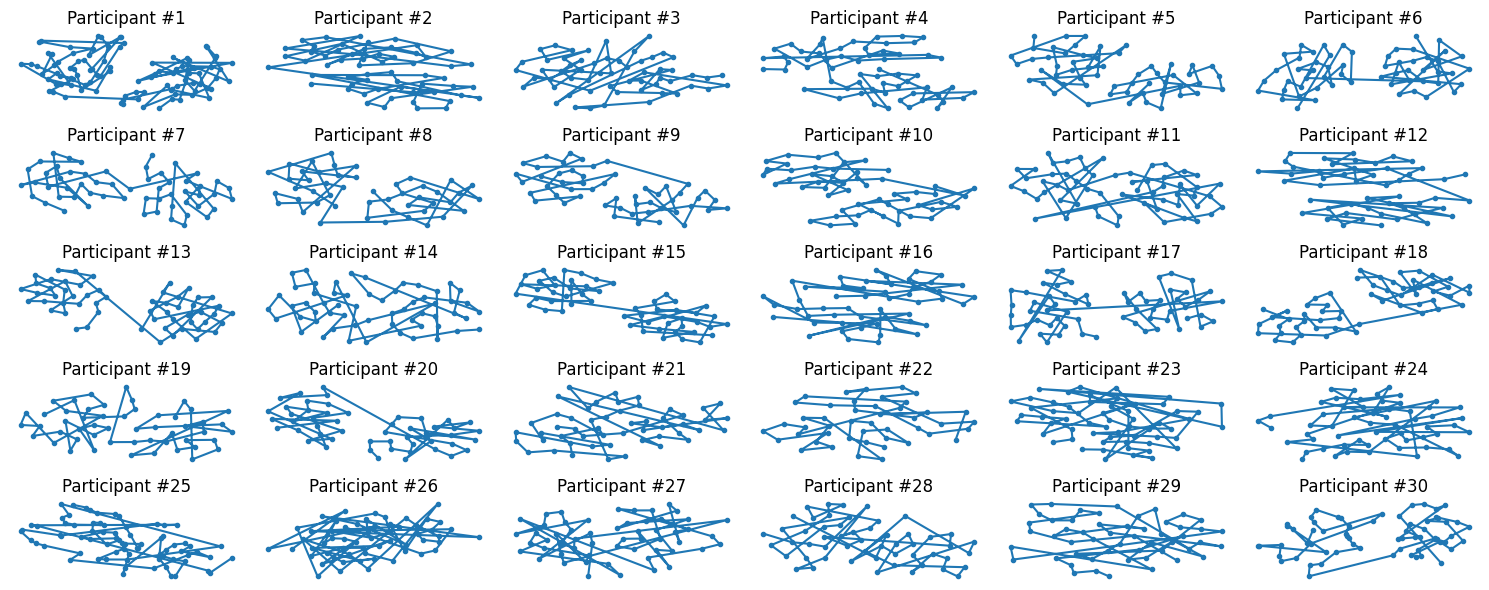

In [19]:
fig, axarr = plt.subplots(5, 6, figsize = (15, 6))

for person in range(0, 30):
    single_person = both_df[(label == 'WALKING') & (both_df['subject'] == '#{}'.format(person+1))].drop(['subject', 'Data'], axis = 1) # extract only 'WALKING data ex) #1, #2, #3,...

    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)

    # Reduce dimesnions
    pca = PCA(n_components=0.9, random_state = 3)
    tsne_data = pca.fit_transform(tsne_data)

    # Transform data
    tsne = TSNE(random_state = 3)
    tsne_transformed = tsne.fit_transform(tsne_data)

    # Create plot
    axarr[person // 6][person%6].plot(tsne_transformed[:, 0], tsne_transformed[:, 1], '.-') # person // 6: rpw, person % 6: column select (row, column)
    ## tsne=> tsne_transformed[:, 0]: x-axis, tsne_transformed[:, 1]: y-axis
    '''
    finally, t-SNE projects high-dimensional data onto a 2-dimensional plane while preserving the distances between data points--keeping the ones that are close together and those that are fat apart. This allows the originally high-dimensional (n-dimensional) data to be easily visualized.
    '''
    axarr[person // 6][person%6].set_title('Participant #{}'.format(person + 1))
    axarr[person // 6][person%6].axis('off')

plt.tight_layout()
plt.show()

The visialization assumes the data is time series. Two distinct clusters(ex: #1, #6, #7 ...) appear for each participant, suggesting each cluster represents a separate walking session rather than alternate steps. This insight emphasizes the importance of analyzing individual walking experiments for accurate classification.


# [Hyung Jun]: Acutyally, I couldn't get it well... part 1

### How long does the particaipant walk?

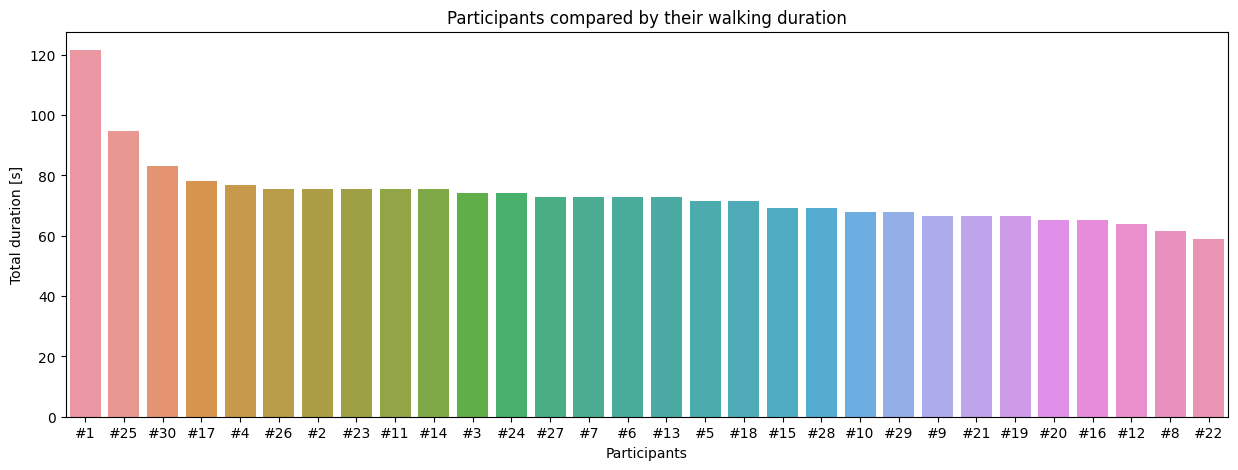

In [24]:
# group the data by participant and compute total duration of walking
mask = label == 'WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending = False)

plt.figure(figsize = (15, 5))
sns.barplot(data = plot_data, x = 'subject', y = 'Data')
plt.title('Participants compared by their walking duration')
plt.xlabel('Participants')
plt.ylabel('Total duration [s]')
plt.show()

since the duration of each participant walking is distributed over a range I assume the participants had a fixed walking distance for their experiment rathe than a fixed duration.

### Is there a unique staircase walking style for each participant

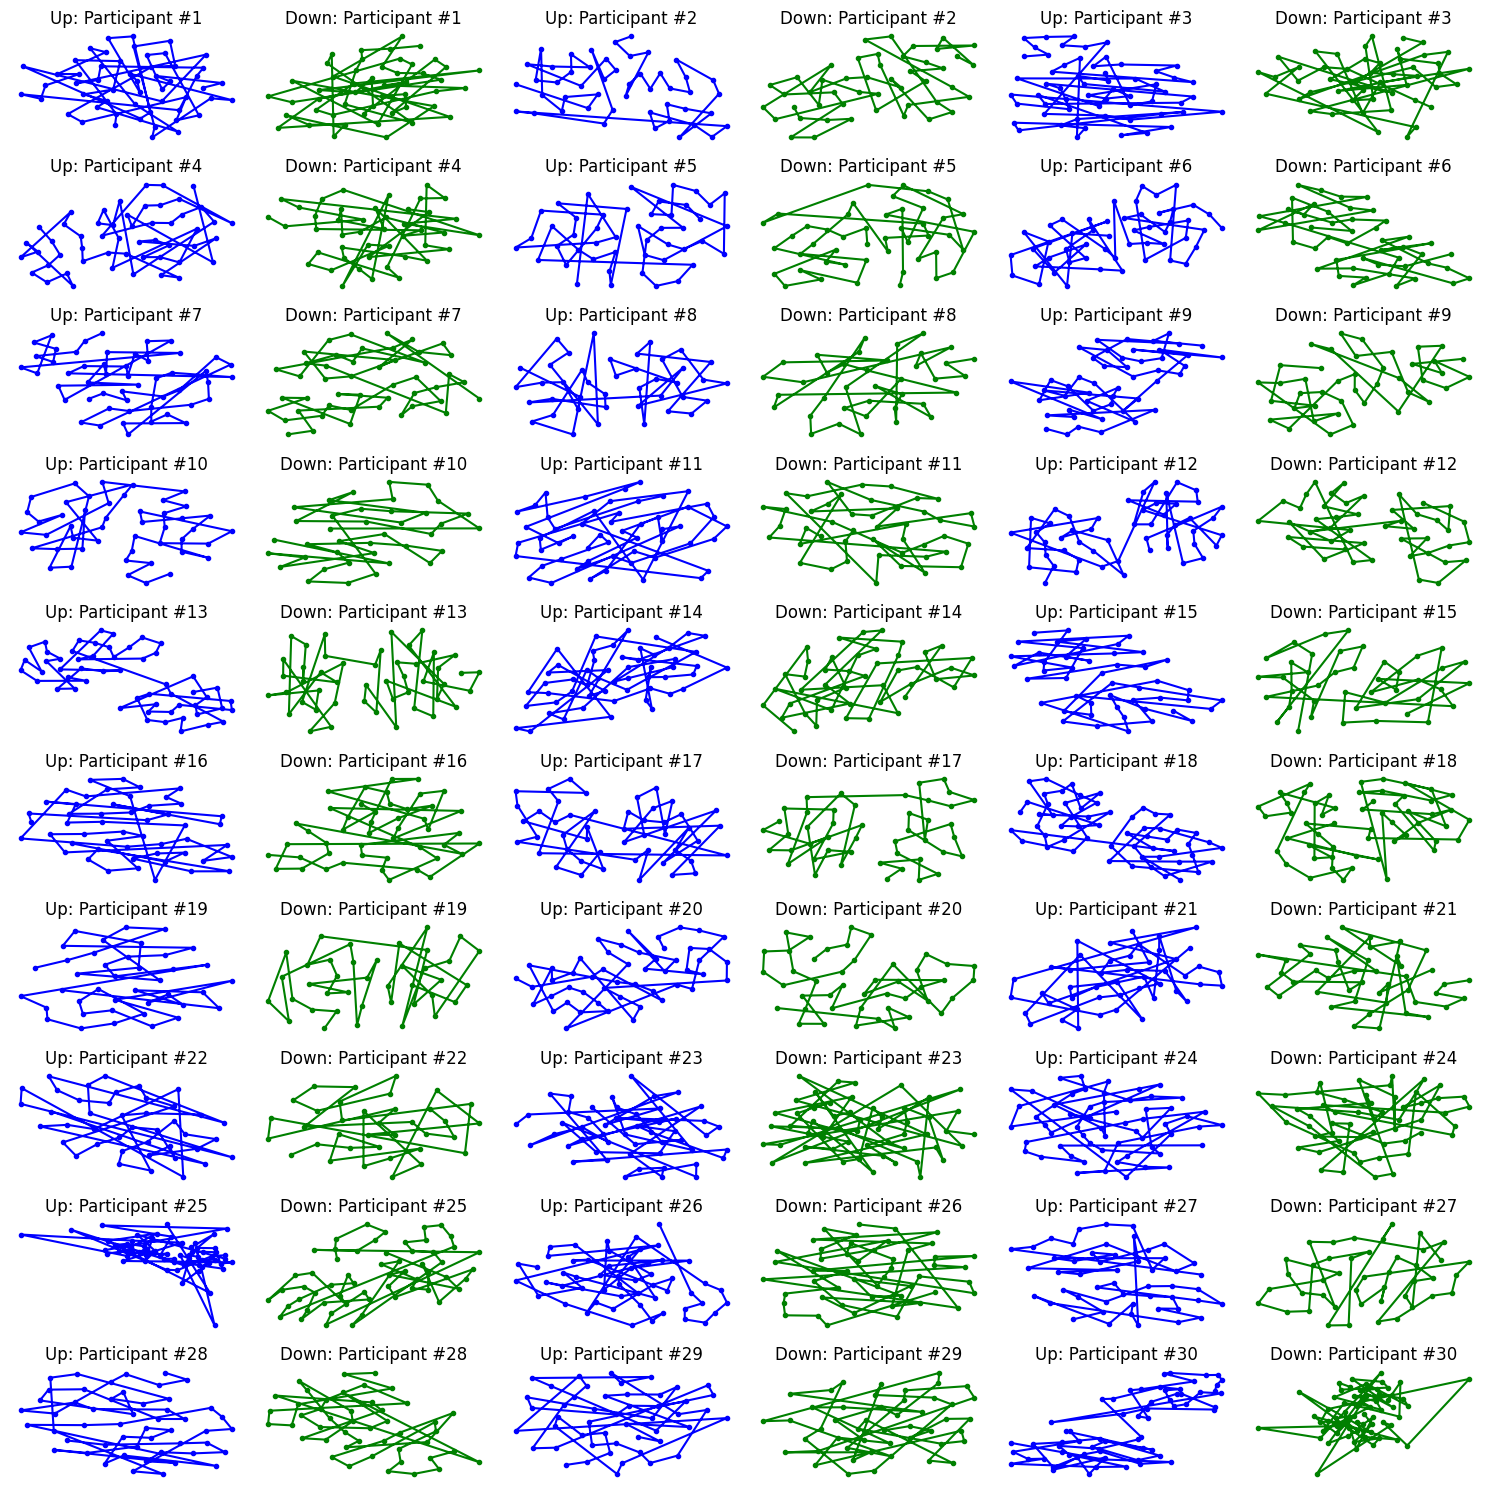

In [29]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)

    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

In most of the plots a structure with two clusters is agin recognizable. Going up and down the stairs for two times is likely for the experiment.
I will review the durations for this assumption with a small experiment on my stairs

# [Hyung Jun]: Actually, I dont'get it well part 2

### Function practice for checking return value

In [16]:
# both_df

In [17]:
# test = both_df.groupby([label, subject_data])['Data']

In [18]:
# test.count().reset_index().groupby('Activity').mean()